In [1]:
#!/usr/bin/env python

# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""Train a Fast R-CNN network on a region of interest database."""
import os
import sys
import scipy
import random
import theano
import lasagne
import numpy as np
import cPickle as pickle
import theano.tensor as T
import matplotlib.pyplot as plt

from IPython import display
from scipy.misc import imread, imsave, imresize
from sklearn.cross_validation import train_test_split

%matplotlib inline

import _init_paths
from fast_rcnn.train import get_training_roidb, train_net, filter_roidb, SolverWrapper
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from datasets.factory import get_imdb
from custom import utilities, models, net
import datasets.imdb
import argparse
import pprint
import numpy as np
import sys

def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Train a Fast R-CNN network')
    parser.add_argument('--iters', dest='max_iters',
                        help='number of iterations to train',
                        default=40000, type=int)
    parser.add_argument('--cfg', dest='./experiments/cfgs/rcnn.yml',
                        help='optional config file',
                        default=None, type=str)
    parser.add_argument('--imdb', dest='imdb_name',
                        help='dataset to train on',
                        default='voc_2007_trainval', type=str)
    parser.add_argument('--rand', dest='randomize',
                        help='randomize (do not use a fixed seed)',
                        action='store_true')
    parser.add_argument('--set', dest='set_cfgs',
                        help='set config keys', default=None,
                        nargs=argparse.REMAINDER)

    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)

    args = parser.parse_args()
    return args

def combined_roidb(imdb_names):
    def get_roidb(imdb_name):
        imdb = get_imdb(imdb_name)
        print 'Loaded dataset `{:s}` for training'.format(imdb.name)
        imdb.set_proposal_method(cfg.TRAIN.PROPOSAL_METHOD)
        print 'Set proposal method: {:s}'.format(cfg.TRAIN.PROPOSAL_METHOD)
        roidb = get_training_roidb(imdb)
        return roidb

    roidbs = [get_roidb(s) for s in imdb_names.split('+')]
    roidb = roidbs[0]
    if len(roidbs) > 1:
        for r in roidbs[1:]:
            roidb.extend(r)
        imdb = datasets.imdb.imdb(imdb_names)
    else:
        imdb = get_imdb(imdb_names)
    return imdb, roidb

def run_training():
    args = parse_args()

    print('Called with args:')
    print(args)

    if args.cfg_file is not None:
        cfg_from_file(args.cfg_file)
    if args.set_cfgs is not None:
        cfg_from_list(args.set_cfgs)

    print('Using config:')
    pprint.pprint(cfg)

    imdb, roidb = combined_roidb(args.imdb_name)
    print '{:d} roidb entries'.format(len(roidb))

    output_dir = get_output_dir(imdb)
    print 'Output will be saved to `{:s}`'.format(output_dir)

    train_net(roidb, output_dir,
              max_iters=args.max_iters)



Using gpu device 1: Quadro K4200 (CNMeM is enabled with initial size: 20.0% of memory, CuDNN 4007)


In [2]:
def deprocess(img, w = None, h = None, typ = 'float64'):
        
    if not w or not h:
        ims = img.shape
        w = ims[1]
        h = ims[2]
    
    R_CH = img[0]
    G_CH = img[1]
    B_CH = img[2]
    
    iimg = np.zeros((w, h, 3), dtype=typ)
    
    iimg[:,:,0] = R_CH
    iimg[:,:,1] = G_CH
    iimg[:,:,2] = B_CH
    
    return iimg

def preprocess(img, w, h, typ = 'float64'):
    
    if img.shape[0] != w or img.shape[1] != h:
        img = resize(img, w, h)
        
    img = img.astype(typ)
    
    R_CH = img[:,:,0]
    G_CH = img[:,:,1]
    B_CH = img[:,:,2]

    itenzor = np.zeros((1,3, w, h))

    itenzor[0,0] = B_CH
    itenzor[0,1] = G_CH
    itenzor[0,2] = R_CH
    
    return itenzor

def flint(i):
    return int(np.floor(i))

def crop(im, ri):
    xl, yl, xh, yh = ri[1:5]
    xl, yl, xh, yh = flint(xl), flint(yl), flint(xh), flint(yh)
    
    xs = flint(xh-xl)
    ys = flint(yh-yl)
    dat = np.zeros((3, ys, xs))
    dat[0] = im[0][yl:yh,xl:xh]
    dat[1] = im[1][yl:yh,xl:xh]
    dat[2] = im[2][yl:yh,xl:xh]
    
    return dat

def roi_pool(d, r):
    stack = []
    s = 227
    for RoI in r:
        di = int(RoI[0])
        stack.append(preprocess(utilities.resize(deprocess(crop(d[di],RoI), typ='int32'), s, s), s, s, typ='int32'))

    inp = np.vstack(stack)
    return inp

In [3]:
imdb, roidb = combined_roidb("voc_2007_trainval")
print '{:d} roidb entries'.format(len(roidb))
output_dir = get_output_dir(imdb)
roidb = filter_roidb(roidb)

Loaded dataset `voc_2007_trainval` for training
Set proposal method: selective_search
Appending horizontally-flipped training examples...
voc_2007_trainval ss roidb loaded from /home/aphex/Projects/DeepLearning/seminar_6/data/cache/voc_2007_trainval_selective_search_roidb.pkl
done
Preparing training data...
done
10022 roidb entries
Filtered 0 roidb entries: 10022 -> 10022


In [4]:
sw = SolverWrapper(roidb, output_dir)
rdl = sw.solver.roi_data_layer

==========Initializing the SolverWrapper==========
Computing bounding-box regression targets...
bbox target means:
[[ 0.          0.          0.          0.        ]
 [ 0.          0.00379662  0.02754976  0.06469912]
 [ 0.         -0.00138961  0.0633017   0.03448065]
 [ 0.          0.01547897  0.00778036  0.06749826]
 [ 0.         -0.00627642 -0.00140434  0.09385452]
 [ 0.         -0.00389383 -0.07596478  0.14041215]
 [ 0.          0.0029443  -0.01565004  0.09243322]
 [ 0.          0.0007864  -0.00063314  0.08758059]
 [ 0.          0.00526074  0.02774618  0.04674116]
 [ 0.          0.00073211 -0.01874643  0.07139775]
 [ 0.          0.00984952  0.00350275  0.06485032]
 [ 0.          0.01996824  0.08911847 -0.00315299]
 [ 0.          0.00077153  0.02670116  0.05070323]
 [ 0.          0.00817035 -0.00731261  0.05171875]
 [ 0.          0.00332969  0.02667745  0.04701575]
 [ 0.         -0.00740894 -0.04660295  0.11327903]
 [ 0.          0.01492526 -0.01818247  0.10909865]
 [ 0.          0.0

In [8]:
from copy import deepcopy

In [9]:
def fortop(rdl):
    rdl.forward()
    return deepcopy(rdl.top[:3])

In [11]:
import cv2

In [134]:
def roi_layer(dat, RoI):

    s = 227
    l = len(RoI)
    out = []

    z = np.zeros((l,3,s,s))

    for r in RoI:
        ind, left, top, right, bottom = int(r[0]), int(r[1]), int(r[2]),int(r[3]),int(r[4])
        d = dat[ind]
        pic = d[:, top:bottom, left:right]
        pr = cv2.resize(pic.transpose(1,2,0), (s, s), interpolation=cv2.INTER_LINEAR).transpose((2, 0, 1))
        out.append(pr)

    z[:] = out
    return z

In [ ]:
data, roi, labels = fortop(rdl)

In [135]:
zz = roi_layer(data, roi)

In [141]:
dp = deprocess(zz[100], typ='int32')

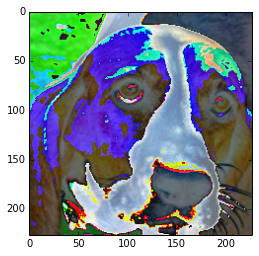

In [142]:
plt.imshow(dp)
plt.show()